In [1]:
import sys
sys.path.append('/home/daisy/geuv/code/transethnic_prs-main/')
print(sys.path)
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path, enet_path
import transethnic_prs.model1.Model1Blk as model1blk

['/home/daisy/geuv', '/home/daisy/geuv/code/transethnic_prs-main', '/home/daisy/geuv', '/home/daisy/geuv/code/transethnic_prs-main/transethnic_prs', '/home/daisy/anaconda3/envs/transethnic_prs/lib/python37.zip', '/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7', '/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/lib-dynload', '', '/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages', '/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages/IPython/extensions', '/home/daisy/.ipython', '/home/daisy/geuv/code/transethnic_prs-main/']


In [2]:
gene = 'ENSG00000075234.12'
gene_name = 'TTC38'

In [3]:
pheno_total = pd.read_csv('data/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt', sep = '\t', index_col = 'TargetID')
target_pheno_total = pheno_total.loc[gene]

b_hat_eur_total = pd.read_csv('data/EUR373.gene.cis.FDR5.all.rs137.txt', sep = '\t')
b_hat_eur_total_grouped = dict(list(b_hat_eur_total.groupby('GENE_ID')))
b_hat_eur_target = b_hat_eur_total_grouped[gene]

eur_sample = pd.read_csv('data/clean/eur_'+gene_name+'_genotype.012.indv', sep = '\t', header = None)
afr_sample = pd.read_csv('data/clean/afr_'+gene_name+'_genotype.012.indv', sep = '\t',header = None)

target_pheno_eur = pd.merge(target_pheno_total, eur_sample, left_index = True, right_on = 0)
target_pheno_afr = pd.merge(target_pheno_total, afr_sample, left_index = True, right_on = 0)

eur_genotype = pd.read_csv('data/clean/eur_'+gene_name+'_genotype.012', sep = '\t', header = None, index_col = 0)
afr_genotype = pd.read_csv('data/clean/afr_'+gene_name+'_genotype.012', sep = '\t', header = None, index_col = 0)

pa = target_pheno_afr.set_index(0)
pe = target_pheno_eur.set_index(0)

sorted_eur_pheno = pd.merge(eur_sample, pe, left_on = 0 , right_index = True, how = 'left')
sorted_afr_pheno = pd.merge(afr_sample, pa, left_on = 0 , right_index = True, how = 'left')
sorted_b_hat_eur = b_hat_eur_target.sort_values(by = 'SNPpos')

X1o = eur_genotype
X2o = afr_genotype
b1_hat = sorted_b_hat_eur['rvalue']
y1o = sorted_eur_pheno[gene]
y2o = sorted_afr_pheno[gene]

In [4]:
X1 = (X1o-X1o.mean())
X2 = (X2o-X2o.mean())
y1 = (y1o-y1o.mean())
y2 = (y2o-y2o.mean())
N1 = 373
N2 = 89

In [5]:
count1 = 0
idx_valid1 = []
for idx1,x1 in enumerate(X1.std()):
    if x1==0:
        count1 +=1
    else:
        idx_valid1.append(idx1)
idx_valid2 = []
count2 = 0
for idx2,x2 in enumerate(X2.std()):
    if x2==0:
        count2 +=1
    else:
        idx_valid2.append(idx2)

In [6]:
R1 = eur_genotype.cov()

In [7]:
X1 = np.array(X1,dtype = np.float64,order = 'C')
X1o = np.array(X1o,dtype = np.float64,order = 'C')
X2 = np.array(X2,dtype = np.float64,order = 'C')
X2o = np.array(X2o,dtype = np.float64,order = 'C')
#b1_hat = np.array(b1_hat, dtype = np.float64,order = 'C')
y1 = np.array(y1, dtype = np.float64, order = 'C')
y1o = np.array(y1o,dtype = np.float64,order = 'C')
y2 = np.array(y2, dtype = np.float64, order = 'C')
y2o = np.array(y2o,dtype = np.float64,order = 'C')
R1 = np.array(R1,dtype = np.float64, order = 'C')

In [8]:
X1 = X1[:,idx_valid2]
X2 = X2[:,idx_valid2]
X1o = X1o[:,idx_valid2]
X2o = X2o[:,idx_valid2]

In [9]:
X1 = X1/np.std(X1o, axis = 0)
X2 = X2/np.std(X2o, axis = 0)

In [10]:
y1 = y1/y1o.std()
y2 = y2/y2o.std()

In [11]:
R1 = np.cov(X1.T)
D_R1 = np.diag(np.diag(R1))
R1.shape

(226, 226)

In [12]:
A1 = X1.T @ X1
A1_t = (N1-1)*R1
#b1_t = (N1-1) * (D_R1 @ b1_hat) ? b1_hat maybe after filtered?
b1 = X1.T @ y1

In [13]:
X1 = np.array(X1,dtype = np.float64,order = 'C')
X2 = np.array(X2,dtype = np.float64,order = 'C')

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X2,y2,test_size = 0.2, random_state = 0)
X_train.shape,X_test.shape

((71, 226), (18, 226))

In [17]:
kf = KFold(n_splits=5)
kf.get_n_splits([X_train,y_train])

5

In [19]:
Max1=0
for train_index, test_index in kf.split(X_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_t = X_train[train_index]
    X_v = X_train[test_index]
    y_t = y_train[train_index]
    y_v = y_train[test_index]
    mod = model1blk.Model1Blk([A1],[b1],[X_t],y_t)
    beta_mat_en, lambda_seq_en, niters_en, tols_en, convs_en = mod.solve_path(alpha=0.1)
    Max2 = 0
    for i in range(100):
        beta_hat = beta_mat_en[:,i]
        y_v_hat = X_v @ beta_hat
        correlation_matrix = np.corrcoef(y_v_hat, y_v)
        correlation_yvhat_yv = correlation_matrix[0,1]
        r2 = correlation_yvhat_yv**2
        if r2>Max2:
            Max2=r2
            idx = i
    print(Max2)
    if Max2>Max1:
        Max1=Max2
        lam=lambda_seq_en[idx]
        beta_h=beta_mat_en[:,idx]

print(Max1,idx,lam,beta_h)
    
       
                               

TRAIN: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
 63 64 65 66 67 68 69 70] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/daisy/anaconda3/envs/transethnic_prs/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.7970836264510585
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65 66 67 68 69 70] TEST: [15 16 17 18 19 20 21 22 23 24 25 26 27 28]
0.8487338428629556
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65 66 67 68 69 70] TEST: [29 30 31 32 33 34 35 36 37 38 39 40 41 42]
0.8272194170626285
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 57 58 59 60 61
 62 63 64 65 66 67 68 69 70] TEST: [43 44 45 46 47 48 49 50 51 52 53 54 55 56]
0.7803197346418219
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56] TEST: [57 58 59 60 61 62 63 64 65 66 67 68 69 

In [20]:
y_hat_test.mean()

NameError: name 'y_hat_test' is not defined

0.38396474885930176


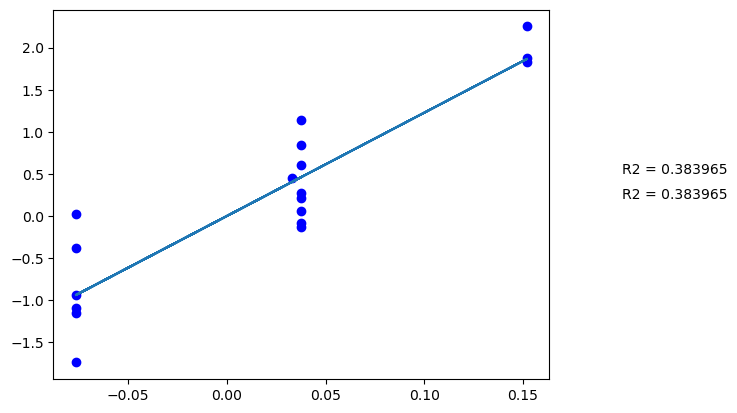

In [40]:
y_hat_test= X_test @ beta_h
correlation_test_matrix = np.corrcoef(y_hat_test, y_test)
correlation_test = correlation_matrix[0,1]
r2 = correlation_test**2
print(r2)
m, b = np.polyfit(y_hat_test, y_test, 1)
plt.scatter(y_hat_test, y_test, color = "blue")
plt.plot(y_hat_test,m*y_hat_test+b)
plt.text(0.2,0.5,f"R2 = %f" %r2)
plt.text(0.2,0.2,f"R2 = %f" %r2)
plt.show()

In [21]:
m

NameError: name 'm' is not defined

In [ ]:
mod1 = model1blk.Model1Blk([A1], [b1], [X2], y2)

In [ ]:
l1_ratio = 0.1
t = time.time()
beta_mat_en, lambda_seq_en, niters_en, tols_en, convs_en = mod1.solve_path(alpha=l1_ratio) 
print(f'Run time = {time.time()-t} s')

In [ ]:
beta_mat_en[2]

In [ ]:
# lasso 
t = time.time()
beta_mat_lasso, lambda_seq_lasso, niters_lasso, tols_lasso, convs_lasso = mod1.solve_path(alpha=1) 
print(f'Run time = {time.time()-t} s')

In [ ]:
y2_hat_lasso = X2 @ beta_mat_lasso[:,-1:]
plt.scatter(y2, y2_hat_lasso, color = "blue")
plt.plot(y2,y2,color = 'g')
plt.show()

In [ ]:
y2_hat_en = X2 @ beta_mat_en[:,-1:]
plt.scatter(y2, y2_hat_en, color = "blue")
plt.plot(y2,y2,color = 'g')
plt.show()

In [ ]:
scipy.optimize

In [ ]:
from scipy import optimize

In [ ]:
beta = np.zeros(R1.shape[0])

In [ ]:
#lasso:
def lasso_fun(beta):
    term1 = beta.T @ A1 @ beta - 2 * b1.T @ beta
    term2 = np.linalg.norm(y2 - X2 @ beta)**2 #L2 norm should be squared here(least square)
    penalty = np.linalg.norm(beta, ord = 1)
    return term1 + term2 + penalty

In [ ]:
t = time.time()
result = optimize.minimize(lasso_fun, beta)
print(f'Run time = {time.time()-t} s')

In [ ]:
y2_hat_lasso_op = X2 @ result.x
plt.scatter(y2, y2_hat_lasso_op, color = "red")# red dots are scipy.optimize results
plt.scatter(y2, y2_hat_lasso, color = "blue")# blue dots are yanyu's solver results
plt.plot(y2,y2,color = 'g')
plt.show()

In [ ]:
def EN(beta):
    term1 = beta.T @ A1 @ beta - 2 * b1.T @ beta
    term2 = np.linalg.norm(y2 - X2 @ beta)**2 #L2 norm should be squared here(least square)
    ridge = np.linalg.norm(beta)**2
    lasso = np.linalg.norm(beta, ord = 1)
    penalty = 0.1 * lasso + 0.9 * ridge
    return term1 + term2 + penalty

In [ ]:
t = time.time()
result_EN = optimize.minimize(EN,beta)
print(f'Run time = {time.time()-t} s')

In [ ]:
y2_hat_en_op = X2 @ result_EN.x
plt.scatter(y2, y2_hat_en_op, color = "red")# red dots are scipy.optimize results
plt.scatter(y2, y2_hat_en, color = "blue")# blue dots are yanyu's solver results
plt.plot(y2,y2,color = 'g')
plt.show()